In [1]:
import numpy as np
import h5py
import open3d as o3d
from pathlib import Path
import trimesh
import cv2
import torch
import matplotlib.pyplot as plt
import pprint

from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import smplx
from smplx.body_models import SMPL
from smplx.utils import SMPLOutput

import joblib
from pytorch3d.transforms import (
    rotation_6d_to_matrix,
    matrix_to_quaternion,
    quaternion_to_axis_angle,
)

from src.Network import point_net_ssg
from src.surfaceem import surface_EM_depth
from src.utils import farthest_point_sample

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load data and models

In [2]:
h5file = "demo/demo_lidar/Hong Lidar 13.hdf5"
save_dir = Path(h5file).parent / "frames"
save_dir.mkdir(parents=True, exist_ok=True)

h5 = h5py.File(h5file, "r")

In [80]:
device = "cuda"

# YOLO detection
yolomodel = YOLO("sam_models/yolov8n.pt").to(device)

# Segment anything
sam = sam_model_registry["vit_h"](checkpoint="sam_models/sam_vit_h_4b8939.pth")
mask_predictor = SamPredictor(sam.to(device))

# SMPL
smplmodel_folder = "smpl_models"
gender = "male"  # male/female/neutral
smplmodel = smplx.create(
    smplmodel_folder, model_type="smpl", gender=gender, ext="pkl"
).to(device)
faces = smplmodel.faces

SMPL_meanparams = "./smpl_models/neutral_smpl_mean_params.h5"
# depthmodel_path = "./pretrained/model_best_depth.pth"
depthmodel_path = "./pretrained/model_best_pt.pth"
SMPL_downsample = "./smpl_models/SMPL_downsample_index.pkl"
depthmodel = (
    point_net_ssg(smpl_mean_file=SMPL_meanparams, device=device).to(device).eval()
)
depthmodel.load_state_dict(torch.load(depthmodel_path, map_location=device))

loaded_index = joblib.load(SMPL_downsample)
selected_index = loaded_index["downsample_index"]
depthEM = surface_EM_depth(
    smplxmodel=smplmodel,
    batch_size=1,
    num_iters=100,
    selected_index=selected_index,
    device=device,
)

### Detection and segmentation

In [121]:
idx = 20

key = f"{idx:08d}"
print("showing frame: ", key)
distance = h5["frames"][key]["Distance"][()] / 1000
amplitude = h5["frames"][key]["Amplitude"][()]

dist_max = min(8, distance.max())
dist_image = np.clip((distance / dist_max * 255), 0, 255).astype(np.uint8)
dist_image = np.repeat(dist_image[:, :, np.newaxis], 3, axis=2)
# dist_image = cv2.applyColorMap(dist_image, cv2.COLORMAP_JET)

showing frame:  00000020



0: 480x640 1 person, 3 chairs, 5.0ms
Speed: 9.0ms preprocess, 5.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


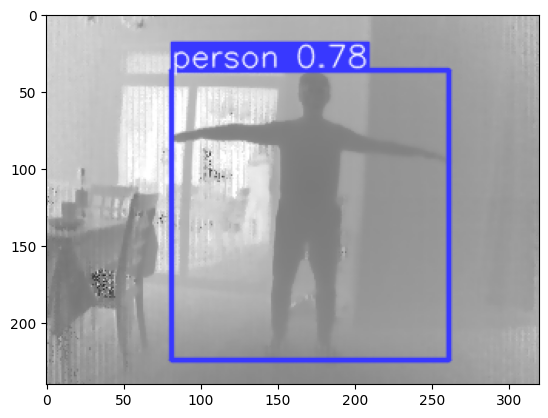

In [122]:
detections = yolomodel(dist_image)[0]
# Find the max person box
detections = detections[detections.boxes.cls == 0]
argmax = torch.argmax(detections.boxes.conf)

plt.imshow(detections.plot())
plt.show()

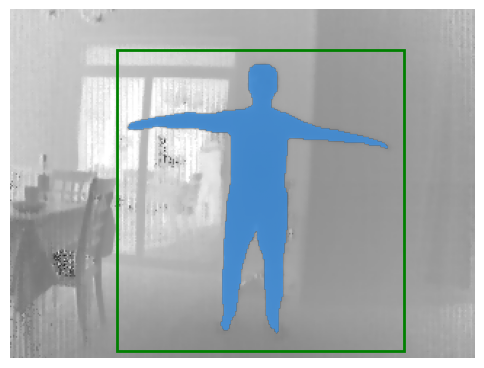

In [128]:
mask_predictor.set_image(dist_image)

# enlarge box by 0.1*width and 0.1*height
box = detections.boxes.xyxy[argmax].data.cpu().numpy()
scale = 0.05
width, height = box[2] - box[0], box[3] - box[1]
box[0] = box[0] - scale * width
box[1] = box[1] - scale * height
box[2] = box[2] + scale * width
box[3] = box[3] + scale * height
# make sure the box is in the image
image_h, image_w = dist_image.shape[:2]
box[0] = max(0, box[0])
box[1] = max(0, box[1])
box[2] = min(image_w-1, box[2])
box[3] = min(image_h-1, box[3])

masks, scores, logits = mask_predictor.predict(box=box, multimask_output=False)
mask = masks[0].astype(np.uint8)


# enlarge the mask with dilation opeartion
def enlarge_mask(mask, ksize=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ksize, ksize))
    enlarged_mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    return enlarged_mask


# mask = enlarge_mask(mask, ksize=2)


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


plt.figure(figsize=(6, 6))
plt.imshow(dist_image)
show_box(box, plt.gca())
show_mask(mask, plt.gca())
plt.axis("off")
plt.show()

### Depth to point cloud

In [129]:
def create_cloud_from_distance_image(
    distance: np.array, rays: np.array, horizontal_binning: bool, vertical_binning: bool
):
    # map the distance image (m x n) to a point cloud (m x n x 3)
    slicing = [1, 1]
    if horizontal_binning:
        slicing[0] = 2
    if vertical_binning:
        slicing[1] = 2
    # take subset of rays based on binning configuration
    rays_small = rays[:: slicing[1], :: slicing[0], :]
    cloud = distance[..., np.newaxis] * rays_small
    return cloud


rays = h5["recording_information"]["rays"][()]
cloud = create_cloud_from_distance_image(distance, rays, False, False)
keep = (amplitude > 100) & (mask > 0)

min_dist, max_dist = np.quantile(distance[keep], [0.0, 0.9])
keep &= (distance > min_dist) & (distance < max_dist)

cloud = cloud[keep]
print(cloud[:, 2].max(), cloud[:, 2].min())


# normalize the height to [-1, 1]
scale = (cloud[:, 2].max() - cloud[:, 2].min()) * 0.5
cloud /= scale
cloud[:, 2] = (cloud[:, 2] - cloud[:, 2].min()) - 1

# shift depth to 0
cloud[:, 0] -= cloud[:, 0].min()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cloud[:, [0, 2, 1]])

# o3d.io.write_point_cloud(str(save_dir / f"{key}.ply"), pcd, write_ascii=False)


1.372218695638905 -1.680540055543687


In [130]:
# pcd: o3d.geometry.PointCloud = o3d.io.read_point_cloud(
#     f"demo/demo_lidar/frames/{key}.ply"
# )
# pcd_example: o3d.geometry.PointCloud = o3d.io.read_point_cloud(
#     "demo/demo_depth/00003200.ply"
# )

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.6, origin=[-1, -1, 0]
)
o3d.visualization.draw_geometries([pcd, mesh_frame,])

### Point cloud to SMPL

In [131]:
pts = torch.from_numpy(np.asarray(pcd.points)).float()
index = farthest_point_sample(pts.unsqueeze(0), npoint=2048).squeeze()
pts = pts[index]

# move to center
trans = torch.mean(pts, dim=0, keepdim=True)
pts = torch.sub(pts, trans)
point_arr = torch.transpose(pts, 1, 0)
point_arr = point_arr.unsqueeze(0).to(depthmodel.device)
point_arr2 = pts.unsqueeze(0).to(depthmodel.device)

# do the inference
with torch.no_grad():
    pred_shape, pred_pose_body, pred_trans, pred_R6D = depthmodel(point_arr)
pred_R6D_3D = quaternion_to_axis_angle(
    matrix_to_quaternion((rotation_6d_to_matrix(pred_R6D)))
)

pred_pose = torch.zeros(1, 72).to(depthmodel.device)
pred_betas = torch.zeros(1, 10).to(depthmodel.device)
pred_cam_t = torch.zeros(1, 3).to(depthmodel.device)
trans_back = torch.zeros(1, 3).to(depthmodel.device)

pred_pose[0, 3:] = pred_pose_body.unsqueeze(0).float()
pred_pose[0, :3] = pred_R6D_3D.unsqueeze(0).float()
pred_cam_t[0, :] = pred_trans.unsqueeze(0).float()
trans_back[0, :] = trans.unsqueeze(0).float()

pred_pose[0, 16 * 3 : 18 * 3] = torch.Tensor([0, 0, 0, 0, 0, 0]).unsqueeze(0).float()
new_opt_vertices, new_opt_joints, new_opt_pose, new_opt_betas, new_opt_cam_t = depthEM(
    pred_pose.detach(), pred_betas.detach(), pred_cam_t.detach(), point_arr2
)

smpl_output: SMPLOutput = smplmodel(
    betas=new_opt_betas,
    global_orient=new_opt_pose[:, :3],
    body_pose=new_opt_pose[:, 3:],
    transl=new_opt_cam_t + trans_back,
    return_verts=True,
)
smpl_output.transl = new_opt_cam_t + trans_back
mesh = trimesh.Trimesh(
    vertices=smpl_output.vertices.detach().cpu().numpy().squeeze(),
    faces=smplmodel.faces,
    process=False,
)
# mesh.export(opt.dirs_save + filename_pure + "_EM.ply")

In [132]:
o3d.visualization.draw_geometries([mesh.as_open3d, mesh_frame, pcd])

#### Optimize SMPL

In [133]:
from pytorch3d.loss import point_mesh_face_distance, chamfer_distance
from pytorch3d.structures import Meshes, Pointclouds
from tqdm import tqdm

In [148]:
betas = smpl_output.betas.detach().clone()
body_pose = smpl_output.body_pose.detach().clone()
global_orient = smpl_output.global_orient.detach().clone()
transl = smpl_output.transl.detach().clone()

pcd_torch = Pointclouds([torch.from_numpy(np.asarray(pcd.points)).float()]).to(
    depthmodel.device
)


betas.requires_grad_()
transl.requires_grad_()
global_orient.requires_grad_()
body_pose.requires_grad_()
optimizer = torch.optim.Adam([betas, transl, global_orient], lr=0.002)



In [149]:
steps = 500
print_interval = 20
for i in range(steps):
    new_smpl_output = smplmodel(
        betas=betas,
        global_orient=global_orient,
        body_pose=body_pose,
        transl=transl,
        return_verts=True,
    )

    optimizer.zero_grad()

    # Loss
    new_meshes = Meshes(
        verts=[new_smpl_output.vertices[0]], faces=[smplmodel.faces_tensor]
    )
    loss_point_to_mesh = point_mesh_face_distance(new_meshes, pcd_torch)
    loss_chamfer, _ = chamfer_distance(
        pcd_torch, new_smpl_output.vertices, single_directional=True
    )
    loss = loss_point_to_mesh * 1 + loss_chamfer * 200
    
    if i % print_interval == 0:
        # bar.set_description(f"Loss={loss.item():.3f}")
        print(f"Step={i}, Loss={loss.item():.3f}")

    # Step
    loss.backward()
    optimizer.step()

Step=0, Loss=0.107
Step=20, Loss=0.089
Step=40, Loss=0.078
Step=60, Loss=0.071
Step=80, Loss=0.066
Step=100, Loss=0.062
Step=120, Loss=0.060
Step=140, Loss=0.058
Step=160, Loss=0.056
Step=180, Loss=0.054
Step=200, Loss=0.053
Step=220, Loss=0.053
Step=240, Loss=0.052
Step=260, Loss=0.051
Step=280, Loss=0.051
Step=300, Loss=0.050
Step=320, Loss=0.049
Step=340, Loss=0.049
Step=360, Loss=0.049
Step=380, Loss=0.048
Step=400, Loss=0.048
Step=420, Loss=0.048
Step=440, Loss=0.047
Step=460, Loss=0.047
Step=480, Loss=0.047


In [150]:
mesh = trimesh.Trimesh(
    vertices=new_smpl_output.vertices.detach().cpu().numpy().squeeze(),
    faces=smplmodel.faces,
    process=False,
)

In [151]:
o3d.visualization.draw_geometries([mesh.as_open3d, mesh_frame, pcd])

### Body measurement

In [138]:
from src.extract_measurements import extract_measurements

In [139]:
vertices = new_smpl_output.vertices.data.cpu().numpy()[0]
extract_measurements(height=170, vertices=vertices)

mesh = trimesh.Trimesh(vertices=vertices, faces=smplmodel.faces, process=False)
mesh.show()

height: 170.000000
waist: 99.901218
belly: 98.061003
chest: 103.472792
wrist: 17.302558
neck: 35.561322
arm length: 53.047978
thigh: 57.558560
shoulder width: 45.469640
hips: 108.714927
ankle: 21.276311


In [140]:
# To A pose
body_pose = torch.zeros_like(new_smpl_output.body_pose)
body_pose[:, 50 - 3] = 5.6
body_pose[:, 53 - 3] = -5.6

output = smplmodel(betas=new_smpl_output.betas, body_pose=body_pose)
vertices_a = output.vertices.data.cpu().numpy()[0]

In [141]:
extract_measurements(height=170, vertices=vertices_a)

mesh_a = trimesh.Trimesh(vertices=vertices_a, faces=smplmodel.faces, process=False)
mesh_a.show()

height: 170.000000
waist: 99.958922
belly: 99.544922
chest: 106.504974
wrist: 17.915256
neck: 38.677273
arm length: 54.052676
thigh: 57.076896
shoulder width: 46.052980
hips: 105.758364
ankle: 22.455578


In [142]:
from body_measurements.measurement import Body3D

measurement_names = "height, shoulder_length, chest_length, hip_length, waist_length, thigh_length, outer_leg_length, inner_leg_length, neck_length, neck_hip_length".split(
    ", "
)

In [143]:
body = Body3D(vertices_a, faces)

body_measurements = body.getMeasurements()
pprint.pprint({k: v for k, v in zip(measurement_names, body_measurements[1:])})

{'chest_length': 1.1326764401034446,
 'height': 1.9021480790384044,
 'hip_length': 1.1724894785958073,
 'inner_leg_length': 0.72,
 'neck_hip_length': 0.6900000000000001,
 'neck_length': 0.46085684170338753,
 'outer_leg_length': 0.85,
 'shoulder_length': 1.0057503607853138,
 'thigh_length': 0.7058974803772042,
 'waist_length': 1.139207385065821}


In [147]:
height = 170
scale = height / body.height()
body_measurements = np.asarray(body.getMeasurements()[1:]) * scale
pprint.pprint({k: v for k, v in zip(measurement_names, body_measurements)})

{'chest_length': 95.2755636712404,
 'height': 160.0,
 'hip_length': 98.62445444844967,
 'inner_leg_length': 60.56310824036224,
 'neck_hip_length': 58.03964539701382,
 'neck_length': 38.76517053804687,
 'outer_leg_length': 71.49811389487209,
 'shoulder_length': 84.59912217086713,
 'thigh_length': 59.376868764838335,
 'waist_length': 95.8249169027241}
